In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, learning_curve
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SMOTE, RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, matthews_corrcoef, f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc
from skopt import BayesSearchCV
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv("C:/Users/Omotehinwa Oluwatosi/Documents/ncs_conf_paper/AutisticData/ASD_Adult/ASD_Adult.csv")
# Loading the dataset
#df = pd.read_csv("C:/Users/Omotehinwa Oluwatosi/Documents/ncs_conf_paper/AutisticData/ASD_Children/ASD_Children.csv")
#df = pd.read_csv("C:/Users/Omotehinwa Oluwatosi/Documents/ncs_conf_paper/AutisticData/ASD_Toddler/ASD_Toddler.csv")
#df = pd.read_csv("C:/Users/Omotehinwa Oluwatosi/Documents/ncs_conf_paper/AutisticData/ASD_Adolescent/ASD_Adolescent.csv")

X = df.drop(['Class_ASD_Traits'], axis=1)
y = df['Class_ASD_Traits']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#ada = ADASYN(random_state=42)
#X_train_smote, y_train_smote = ada.fit_resample(X_train, y_train)

# Applying Borderline-SMOTE to the training set
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Applying Borderline-SMOTE to the training set
# smote = BorderlineSMOTE(random_state=42, sampling_strategy=0.8)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Applying RandomOverSampler to the training set
#ros = RandomOverSampler(random_state=42)
#X_train_smote, y_train_smote = ros.fit_resample(X_train, y_train)

X_train_smote = X_train
y_train_smote = y_train

# Defining the 1D CNN model
def create_model(optimizer='adam', filters=32, kernel_size=3, pool_size=2, dense_units=64):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train_smote.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



In [2]:
# Wrapping the Keras model with scikit-learn's KerasClassifier
estimator = KerasClassifier(build_fn=create_model, epochs=25, batch_size=32, verbose=0)

# Constructing the pipeline with scaling and the KerasClassifier
pipeline = make_pipeline(StandardScaler(), estimator)

# Defining the search space for hyperparameters
search_space = {
    'kerasclassifier__optimizer': ['adam', 'sgd'],
    'kerasclassifier__filters': (32, 64),
    'kerasclassifier__kernel_size': (2, 5),
    'kerasclassifier__pool_size': (2, 5),
    'kerasclassifier__dense_units': (32, 128)
}

# Performing hyperparameter optimization using Tree Parzen Estimator
opt = BayesSearchCV(
    pipeline,
    search_space,
    n_iter=100,
    cv=10,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
opt.fit(X_train_smote, y_train_smote)

# Evaluating the optimized model on the testing set
y_pred = opt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

C:\Users\Omotehinwa Oluwatosi\AppData\Local\Temp\ipykernel_41012\3856655854.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=create_model, epochs=25, batch_size=32, verbose=0)
C:\Users\Omotehinwa Oluwatosi\.conda\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Omotehinwa Oluwatosi\.conda\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Omotehinwa Oluwatosi\.conda\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has b

5/5 [==============================] - 0s 2ms/step


Optimal Hyperparameters: OrderedDict([('kerasclassifier__dense_units', 128), ('kerasclassifier__filters', 64), ('kerasclassifier__kernel_size', 5), ('kerasclassifier__optimizer', 'adam'), ('kerasclassifier__pool_size', 2)])


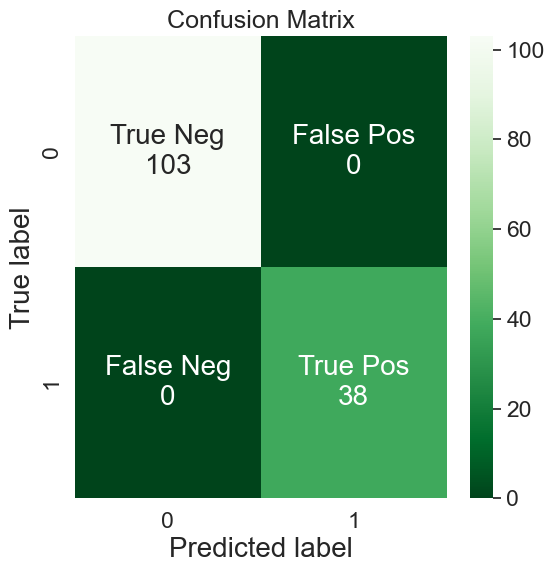

5/5 [==============================] - 0s 1ms/step


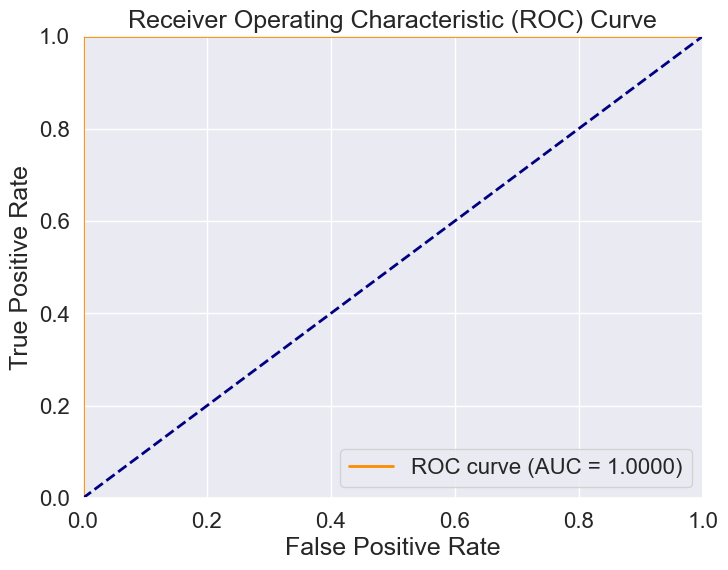

In [4]:
print("Optimal Hyperparameters:", opt.best_params_)

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

plt.tight_layout()
ax = plt.subplot()

# Create the heatmap
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=labels, fmt='', cmap='Greens_r', annot_kws={"size": 20})
# Labels, title and ticks
label_font = {'size':'20'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font)
ax.set_ylabel('True label', fontdict=label_font)
plt.title('Confusion Matrix')
plt.show()

# Evaluating the optimized model on the testing set
y_pred = opt.predict(X_test)
y_pred_prob = opt.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', prop={'size': 16})
plt.show()